In [2]:
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/hemispace' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import hemispace_params as params



#hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = params.data_dir
results_dir = params.results_dir
fig_dir = params.fig_dir


task_info = params.task_info

suf = params.suf
rois = params.rois
hemis = params.hemis



#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')



sub_info = params.sub_info
#extract patients only
sub_info = sub_info[sub_info['group'] == 'patient']

alpha = .05
#mni = load_mni152_brain_mask()

### Calculate percentiles and summary for selectivity and decoding measures

In [20]:
"""
Create a table with symbols indicating whether htey are inside or outside distribution for each condition and ROI
"""


table_names = ['primary','hemi']

all_conds = [['word', 'face', 'tool', 'space'],['word', 'face', 'tool', 'space'],['word', 'face', 'tool', 'space']]
all_rois = [['ventral_visual_cortex', 'ventral_visual_cortex', 'dorsal_visual_cortex', 'dorsal_visual_cortex'], 
        ['hemi','hemi','hemi','hemi']]

summary_val = ['sum_selec_norm', 'mean_act', 'volume', 'acc']
summary_type = ['selectivity','selectivity','selectivity','decoding']
summary_name = ['Summed Selectivity', 'Activation', 'Volume', 'Decoding']
cols = ['word_left', 'word_right','','face_left', 'face_right','', 'tool_left', 'tool_right','', 'space_left', 'space_right','']


for val, sum_type, sum_name in zip(summary_val, summary_type,summary_name):

    for table_name in enumerate(table_names):
        conds = all_conds[table_name[0]]
        rois = all_rois[table_name[0]]

        patient_summary = pd.DataFrame(columns = ['sub_code', 'hemi', 'analysis'] + cols)
        patient_percentiles = pd.DataFrame(columns = ['sub_code', 'hemi', 'analysis'] + cols)
        for code, hemi in zip(sub_info['code'], sub_info['intact_hemi']):
        

        
            #print(val, sum_type, sum_name)
            act_resamples = pd.read_csv(f'{results_dir}/{sum_type}/resamples/{val}_resamples{suf}.csv')

            data_summary = pd.read_csv(f'{results_dir}/{sum_type}/{sum_type}_summary{suf}.csv')

            #extract patients only
            data_summary = data_summary[data_summary['group'] == 'patient']
            patient_vals = []
            patient_percs = []
            # for each sub in data_summary, get the sub's code from sub_info
            for sub in data_summary['sub'].unique():
                sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
                data_summary.loc[data_summary['sub'] == sub, 'sub_code'] = sub_code

            #loop through condition for each patient    
            for cond, roi in zip(conds, rois):
                patient_data = data_summary[(data_summary['sub_code'] == code) & (data_summary['cond'] == cond) & (data_summary['roi'] == roi) & (data_summary['hemi'] == hemi)]
                #check if patient has data for this condition
                if len(patient_data) > 0:
                    for control_hemi in hemis:
                        control_col = f'{cond}_{control_hemi}_{roi}'
                        control_data = act_resamples[control_col]

                        #calcualte 95% CI for control data
                        control_ci = np.percentile(control_data, [(alpha/2)*100, 100-((alpha/2)*100)])
                         #calcualte patients percentile relative to controls
                        patient_perc = stats.percentileofscore(control_data, patient_data[val].values[0])
                        

                        #if patient data is outside of control CI, add to table
                        #only do if below control distribution
                        if patient_data[val].values[0] < control_ci[0]:
                            current_val = '*'
                        else:
                            current_val  = '-'

                        if control_hemi == 'left':
                            left_val = current_val
                            left_perc = patient_perc
                        elif control_hemi == 'right':
                            right_val = current_val
                            right_perc = patient_perc
                        
                    patient_vals = patient_vals + [left_val, right_val, ''] # the blank is there to add a break between conditions
                    patient_percs = patient_percs + [left_perc, right_perc, '']
                else:
                    patient_vals = patient_vals + ['n/a', 'n/a', '']
                    patient_percs = patient_percs + ['n/a', 'n/a', '']

            #add to dataframe
            patient_vals = [code, hemi, sum_name] + patient_vals
            patient_percs = [code, hemi, sum_name] + patient_percs

            
            patient_summary.loc[len(patient_summary)] = patient_vals
            patient_percentiles.loc[len(patient_percentiles)] = patient_percs

        #capitalize hemi
        patient_summary['hemi'] = patient_summary['hemi'].str.capitalize()
        #save table
        patient_summary.to_csv(f'{results_dir}/tables/{val}_summary_{table_name[1]}.csv', index = False)

        #capitalize hemi
        patient_percentiles['hemi'] = patient_percentiles['hemi'].str.capitalize()
        #save table
        patient_percentiles.to_csv(f'{results_dir}/tables/{val}_percentiles_{table_name[1]}.csv', index = False)

#### Calculate whether patient peaks are inside the distribution

In [14]:
sum_type = 'neural_map'

conds = ['word_posterior', 'word_anterior', 'face_posterior', 'face_anterior', 'tool_posterior', 'tool_anterior', 'space_posterior', 'space_anterior']
val = 'dist'
'''Create a table tracking distance'''
patient_summary = pd.DataFrame(columns = ['sub_code', 'hemi'] + conds)
dist_summary = pd.DataFrame(columns = ['sub_code', 'hemi'] + conds)
for code, hemi in zip(sub_info['code'], sub_info['intact_hemi']):

    act_resamples = pd.read_csv(f'{results_dir}/{sum_type}/resample_data.csv')

    data_summary = pd.read_csv(f'{results_dir}/{sum_type}/patient_dists.csv')

    #extract patients only
    data_summary = data_summary[data_summary['group'] == 'patient']
    patient_vals = []
    # for each sub in data_summary, get the sub's code from sub_info
    for sub in data_summary['sub'].unique():
        sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
        data_summary.loc[data_summary['sub'] == sub, 'sub_code'] = sub_code

    current_vals = []
    current_dists = []
    #loop through condition for each patient    
    for cond in conds:
        patient_cond = cond.split('_')
        patient_data = data_summary[(data_summary['sub_code'] == code) & (data_summary['cond'] == patient_cond[0]) &  (data_summary['position'] == patient_cond[1])]

        control_data = act_resamples[cond]


        #calcualte 95% CI for control data
        control_ci = np.percentile(control_data, [(alpha/2)*100, 100-((alpha/2)*100)])
        

        #check if patient has data for this condition
        if len(patient_data) > 0:
            
            #if patient data is outside of control CI, add to table
            if patient_data[val].values[0] > control_ci[1]:
                current_vals.append('*')
            else:
                current_vals.append('-')

            current_dists.append(patient_data[val].values[0] *3)
            
        else:
            current_vals.append('n/a')
            current_dists.append('n/a')



    patient_vals = [code, hemi] + current_vals
    patient_dists = [code, hemi] + current_dists
    #add to dataframe
    patient_summary.loc[len(patient_summary)] = patient_vals
    dist_summary.loc[len(dist_summary)] = patient_dists

    #save
    patient_summary.to_csv(f'{results_dir}/tables/{sum_type}_summary.csv', index = False)
    dist_summary.to_csv(f'{results_dir}/tables/{sum_type}_dists.csv', index = False)



### Calculate whether dice coefficient is within control distribution

In [17]:
sum_type = 'neural_map'

conds = ['word_posterior', 'word_anterior', 'face_posterior', 'face_anterior', 'tool_posterior', 'tool_anterior', 'space_posterior', 'space_anterior']

conds =['word','face','tool','space']
val = 'dice'
'''Create a table tracking distance'''
patient_summary = pd.DataFrame(columns = ['sub_code', 'hemi'] + conds)
dist_summary = pd.DataFrame(columns = ['sub_code', 'hemi'] + conds)
for code, hemi in zip(sub_info['code'], sub_info['intact_hemi']):

    act_resamples = pd.read_csv(f'{results_dir}/{sum_type}/map_overlap_resamples.csv')

    data_summary = pd.read_csv(f'{results_dir}/{sum_type}/full_map_overlap.csv')

    #extract patients only
    data_summary = data_summary[data_summary['group'] == 'patient']
    patient_vals = []
    # for each sub in data_summary, get the sub's code from sub_info
    for sub in data_summary['sub'].unique():
        sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
        data_summary.loc[data_summary['sub'] == sub, 'sub_code'] = sub_code

    current_vals = []
    current_dists = []
    #loop through condition for each patient    
    for cond in conds:
        patient_cond = cond.split('_')
        patient_data = data_summary[(data_summary['sub_code'] == code) & (data_summary['cond'] == patient_cond[0])]

        control_data = act_resamples[cond]


        #calcualte 95% CI for control data
        control_ci = np.percentile(control_data, [(alpha/2)*100, 100-((alpha/2)*100)])
        

        #check if patient has data for this condition
        if len(patient_data) > 0:
            
            #if patient data is outside of control CI, add to table
            if patient_data[val].values[0] < control_ci[0]:
                current_vals.append('*')
            else:
                current_vals.append('-')

            current_dists.append(patient_data[val].values[0])
            
        else:
            current_vals.append('n/a')
            current_dists.append('n/a')



    patient_vals = [code, hemi] + current_vals
    patient_dists = [code, hemi] + current_dists
    #add to dataframe
    patient_summary.loc[len(patient_summary)] = patient_vals
    dist_summary.loc[len(dist_summary)] = patient_dists

    #save
    #patient_summary.to_csv(f'{results_dir}/tables/{sum_type}_summary.csv', index = False)
    #dist_summary.to_csv(f'{results_dir}/tables/{sum_type}_dists.csv', index = False)

In [18]:
patient_summary

,sub_code,hemi,word,face,tool,space
0,XC,left,*,n/a,-,*
1,SI,left,-,-,*,*
2,BI,left,n/a,*,-,-
3,BN,left,-,-,n/a,-
4,EB,right,*,*,*,*
5,KT,right,*,*,n/a,-
6,FO,right,-,*,-,*
7,KN,right,*,*,*,*


In [5]:
def create_histplot(boot_data, sub_data, group,metric, title, save=False):
    bin_range = [np.min(boot_data)-np.std(boot_data), np.max(boot_data)+np.std(boot_data)]
    sns.histplot(boot_data, binrange = bin_range)
    #add x axis label
    plt.xlabel(metric)
    
    for sub, val in zip(sub_data['sub'], sub_data[metric]):
        
        
        #add a line for each patient
        plt.axvline(val, color = 'red')
        rand_int = np.random.randint(100,500)

        #for patients add their code
        if group == 'patient':
            #find code corresponding to sub
            sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
            #add text for each patient
            plt.text(val+(np.std(boot_data)/3), rand_int, sub_code, color = 'red')

    #add title
    plt.title(title)

    #if save is true, save figure
    if save:
        file_name = title.replace(' ','_')
        file_name = f'{metric}_{file_name}{suf}'
        plt.savefig(f'{fig_dir}/hist/indiv/{file_name}.png')
    
    #random number between 100 and 500
   


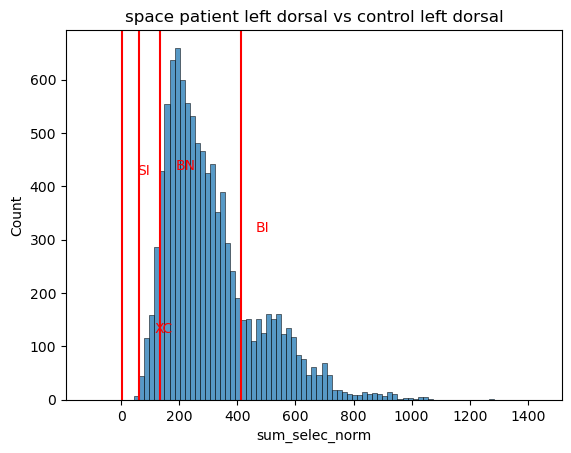

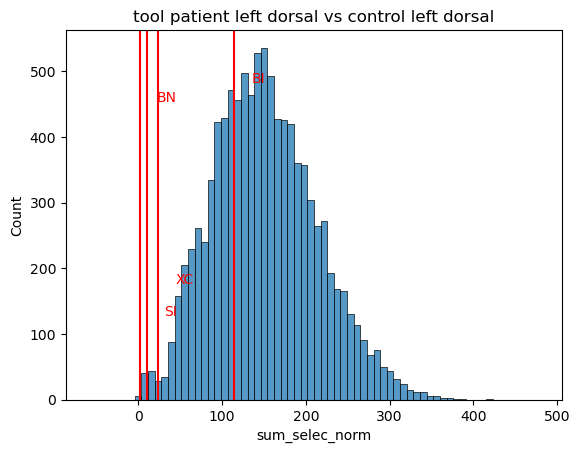

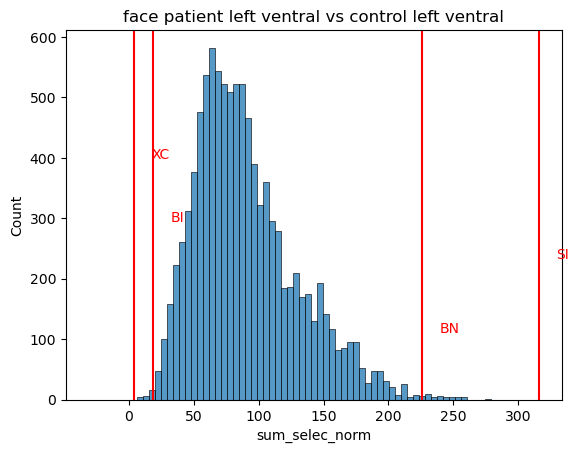

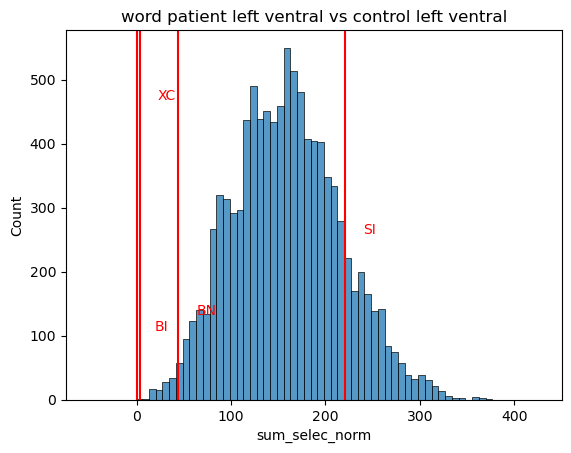

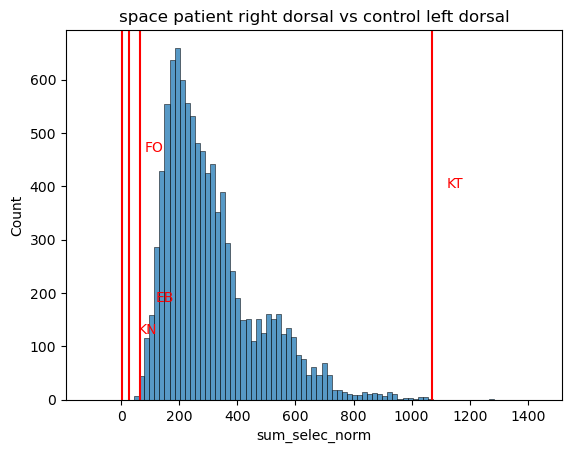

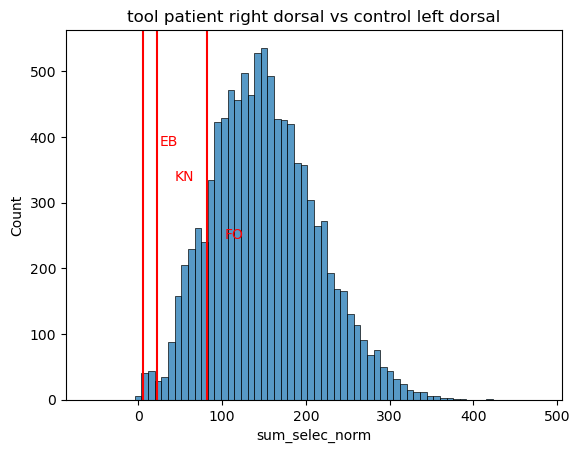

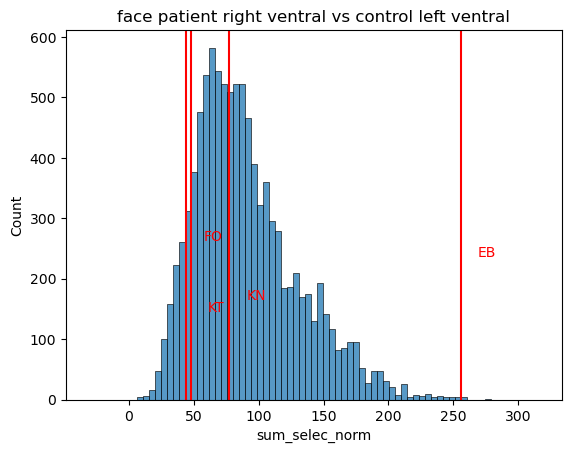

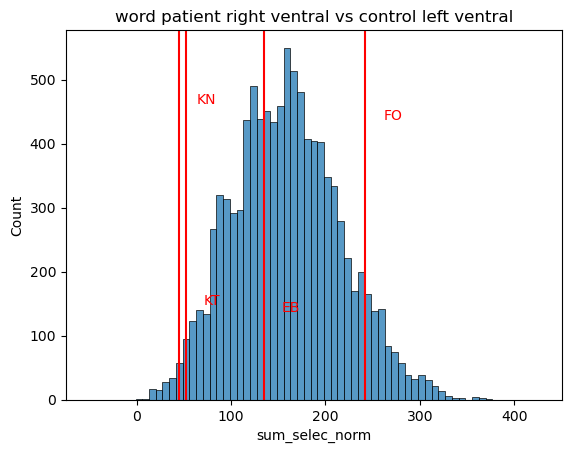

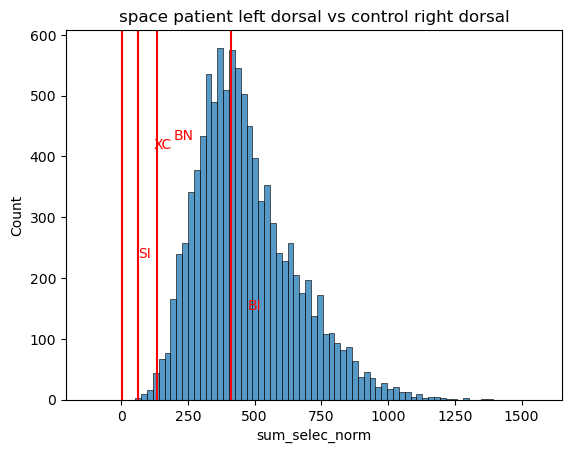

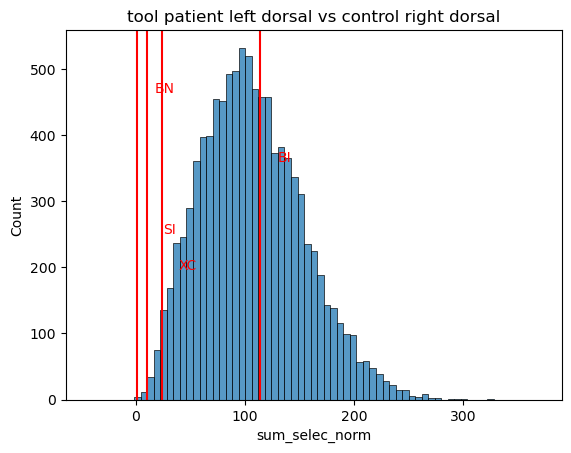

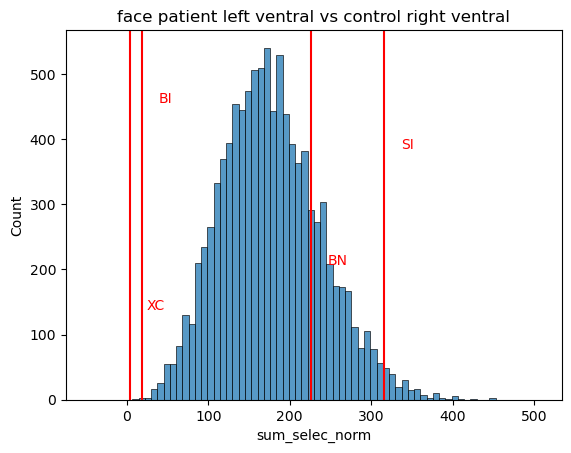

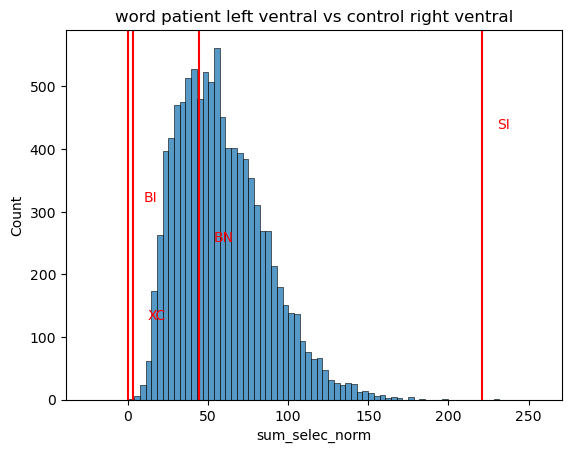

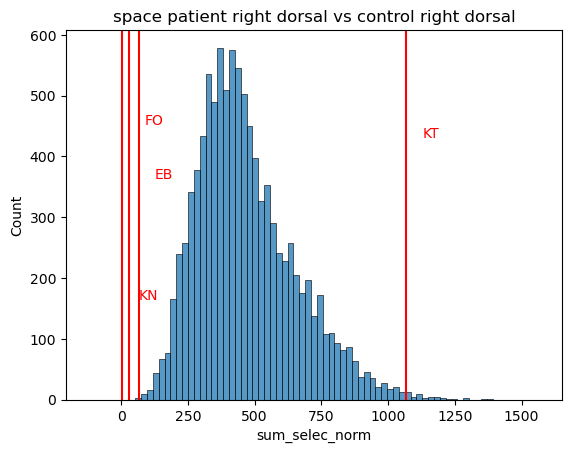

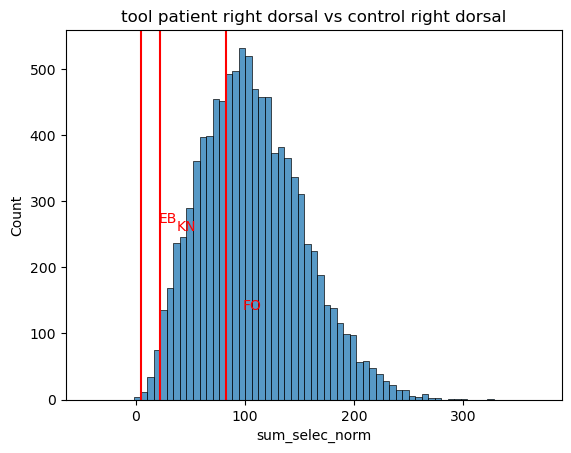

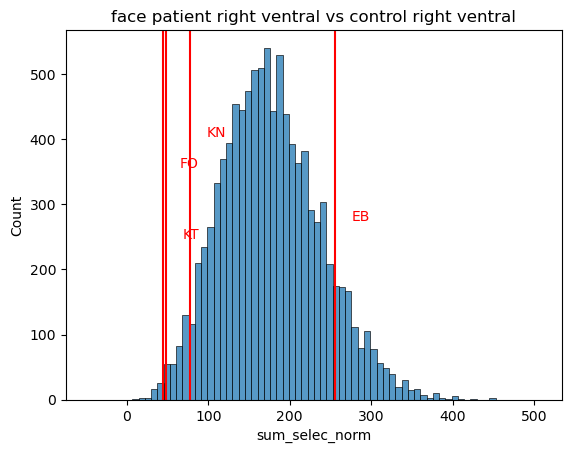

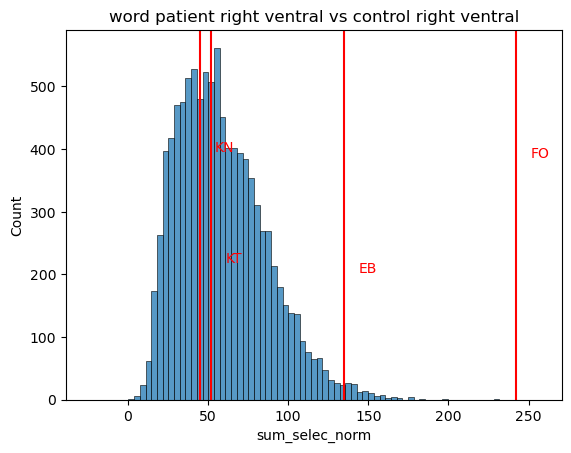

In [7]:
"""
Plot each individual patient's data on distribution of control data
"""

conds = ['space', 'tool','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'ventral_visual_cortex', 'ventral_visual_cortex']

summary_val = ['sum_selec_norm']
for val in summary_val:
    act_resamples = pd.read_csv(f'{results_dir}/resamples/{val}_resamples{suf}.csv')
    for control_hemi in hemis:

        for patient_hemi in hemis:
            for cond, roi in zip(conds, rois):
                control_col = f'{cond}_{control_hemi}_{roi}'

                control_data = act_resamples[control_col]
                
                #extract patient data from summary
                patient_data = data_summary[(data_summary['group'] == 'patient') & (data_summary['cond'] == cond) & (data_summary['hemi'] == patient_hemi) & (data_summary['roi'] == roi)][['sub',val]]
                #sub_names = patient_data = data_summary[(data_summary['group'] == 'patient') & (data_summary['cond'] == cond) & (data_summary['hemi'] == hemi) & (data_summary['roi'] == roi)]
                roi_name = roi.split('_')[0]
                title = f'{cond} patient {patient_hemi} {roi_name} vs control {control_hemi} {roi_name}'
                create_histplot(control_data, patient_data,'patient',val, title)
                plt.pause(.001)


